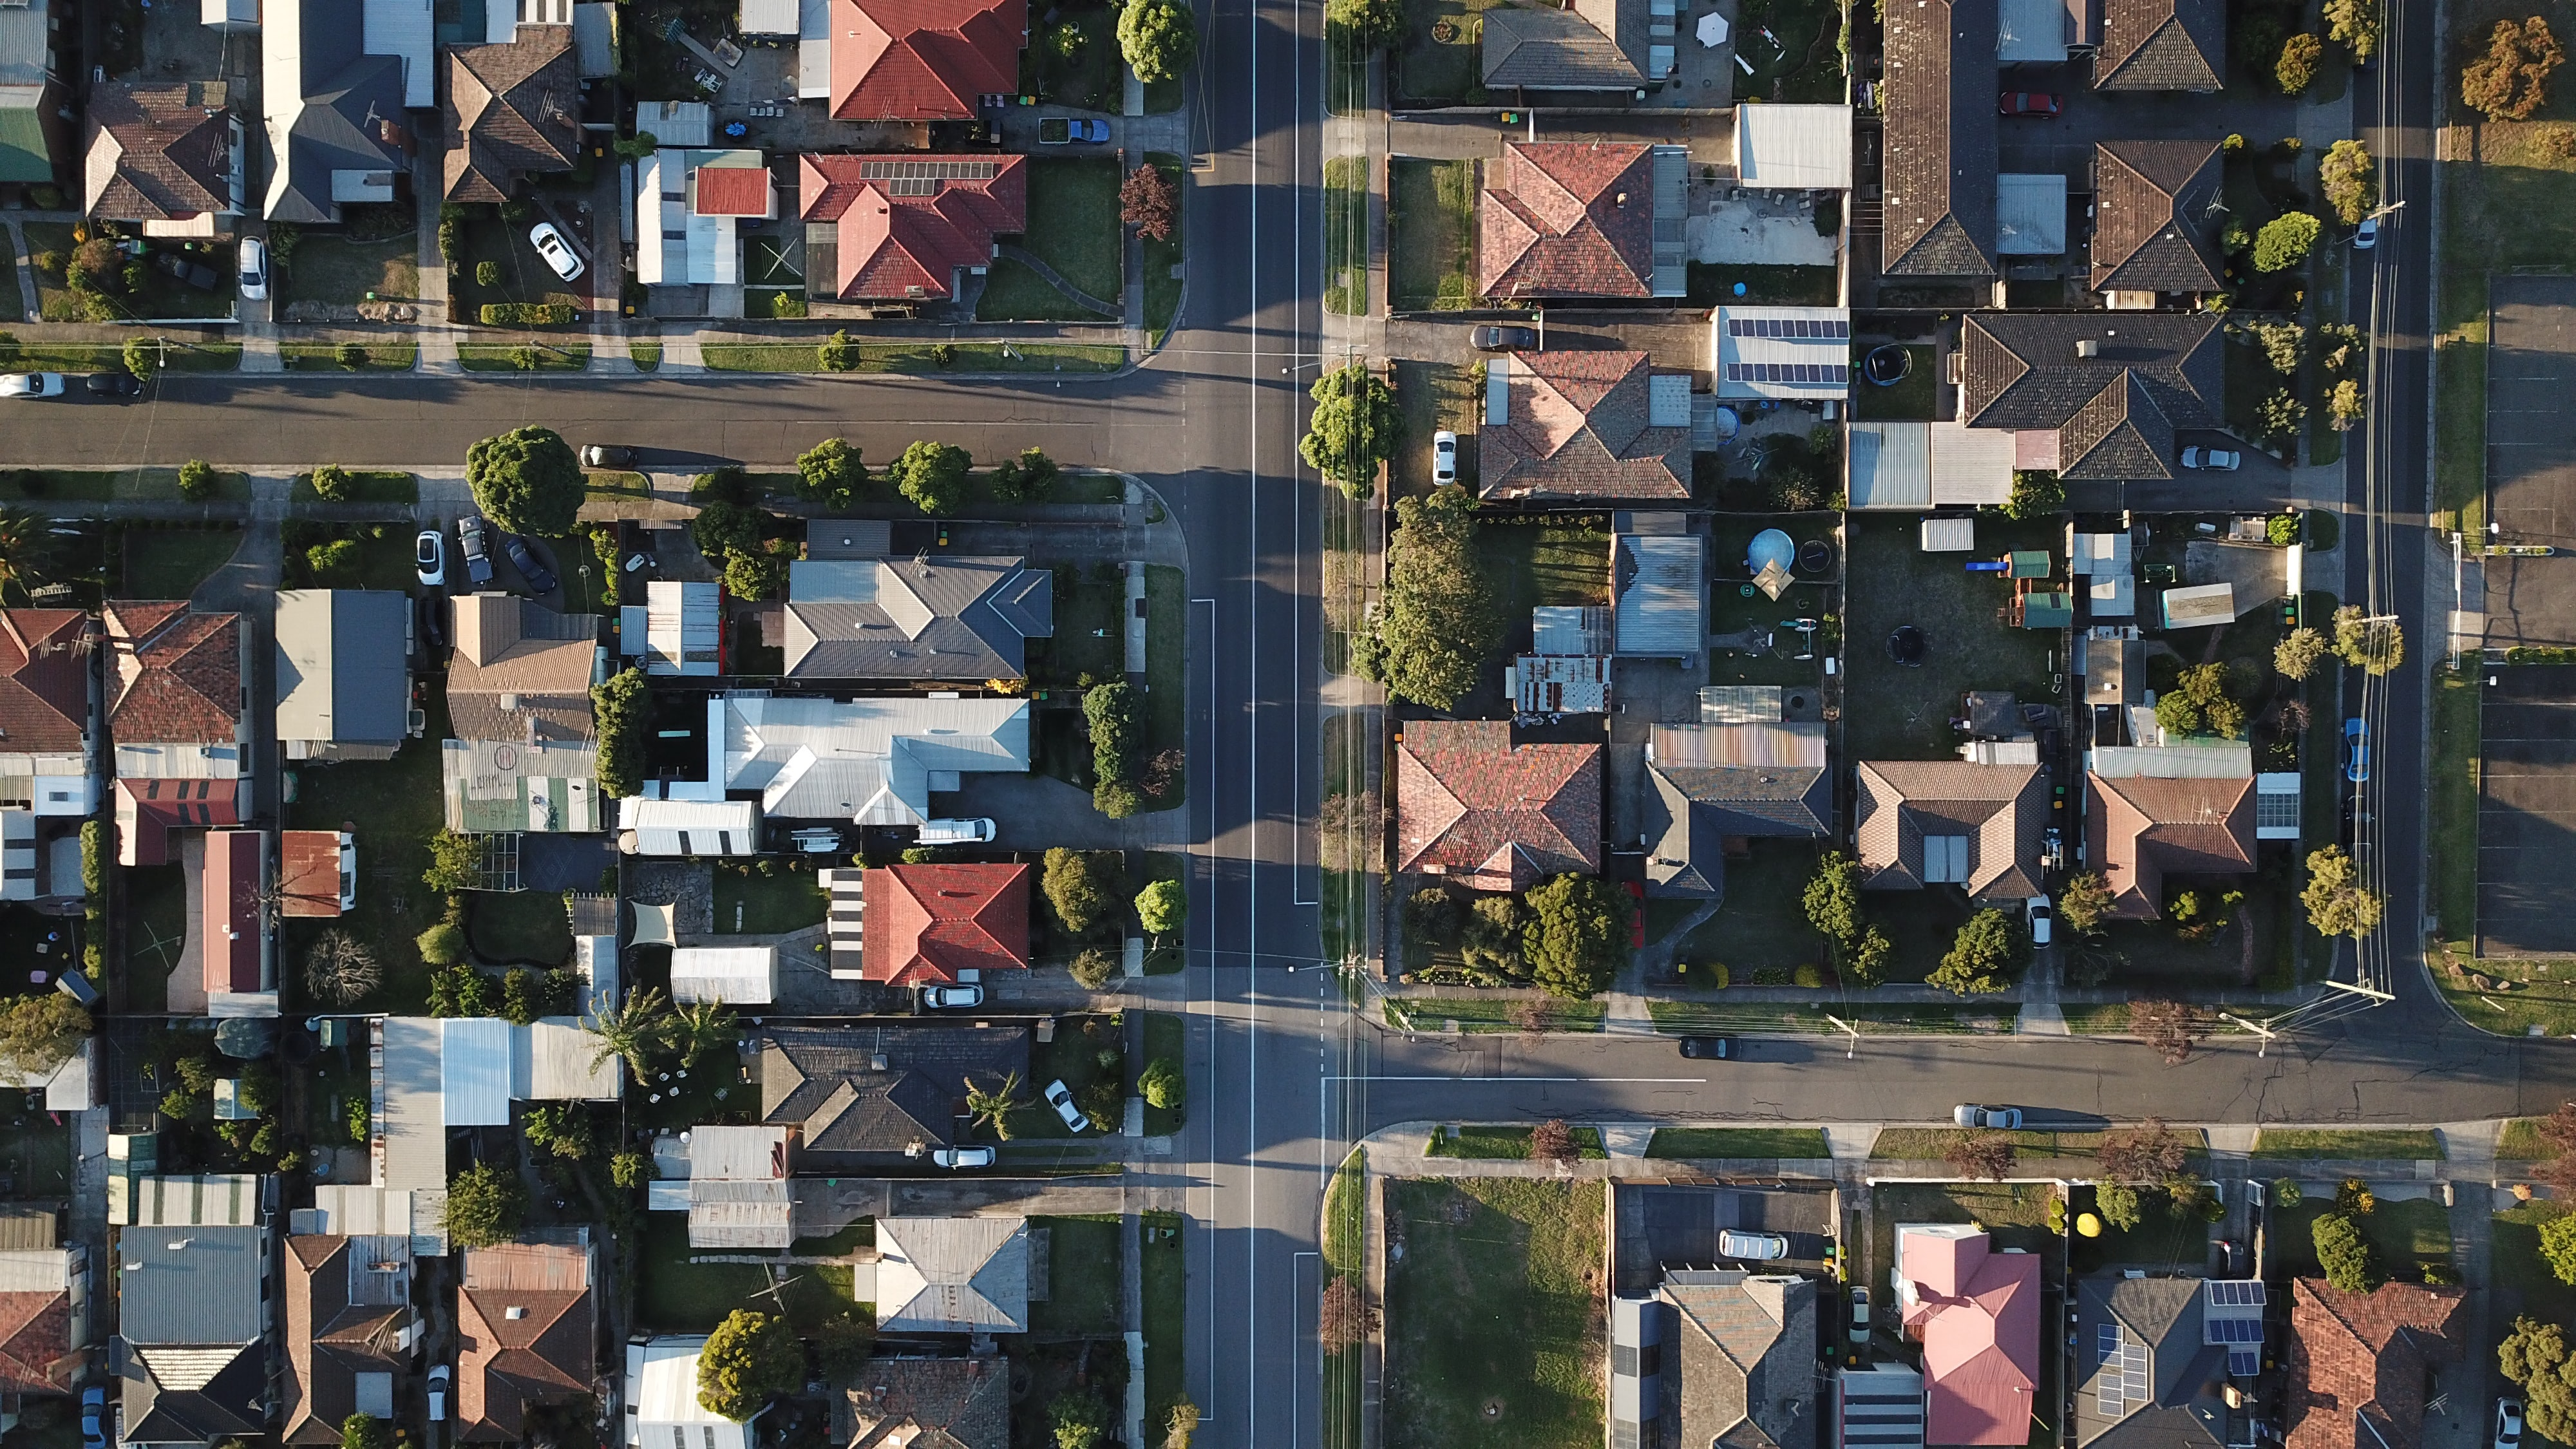

# King County Housing with Multiple Linear Regression 
### Authors: Diane Tunnicliffe, Dana Rausch, Matthew Lipman

## Notebook 1: Business Problem and Data Understading
This notebook contains an introduction to our project, our business problem, the full process of how all our data were obtained, and an exploration of our data with EDA.


## Overview
We have been tasked with analyzing the data of houses in King County. Our goal is to make predictions about the sale price of houses based on certain variables or features, so that they can be used to make profitable decisions by a housing development company. After careful consideration and evaluation of our data, and many iterations of our linear regression models, we have determined that sqare-feet of living space, building grade, and proximity to top schools, great coffee shops, and churches of scientology all are correlated with a higher selling price for a house in King County.

## Business Problem

Our stakeholders in a housing development company are searching for the qualities that lead to higher home sale prices. We will be reviewing building grade, square-footage of living space, and location-related factors such as proximity to schools, coffee shops, parks, and scientology churches to determine which factors are highly correlated with home sale prices.

### Hypotheses  

Null hypothesis (H0): There is no relationship between our features and our target variable, price. 
Alternative hypothesis (Ha): There is a relationship between our features and our target variable, price. 

We will be using a significance level (alpha) of 0.05 to make our determination, and will make our final recommendations accordingly.

## Data Understanding

We utilized a few different data sources for our model so that we could obtain a comprehensive and accurate prediction of home prices. 
* King County House Data: a dataset that we were provided at the onset of the project. This file contains data for 21,597 homes built in King County from 1900 to 2015. Each home in the set contains information regarding features such as number of bedrooms/bathrooms, number of floors, square footage, zip code, condition, and more.  
* Urban Institute Education Data: The Urban Institute is a nonprofit research organization. Their Education Data Explorer "...harmonizes data from all major federal datasets, including the US Department of Education Common Core of Data, the US Department of Education Civil Rights Data Collection, the US Department of Education EDFacts, the US Census Bureau Small Area Income and Poverty Estimates, the US Department of Education Integrated Postsecondary Education Data System, the US Department of Education College Scorecard, and the National Historical Geographic Information System." Custom-generated report provides descriptors such as name and location (lat,long) of school, zip code, and which school district it belongs to.
* Niche.com: school rankings for top King County school districts.
* Yelp API: Used to obtain the top-rated coffee shops for King County.
* Web-scraped data from KingCounty.gov parks website (https://www.kingcounty.gov/services/parks-recreation/parks/parks-and-natural-lands/parksatoz.aspx)
* Scientology church location information from scientology-seattle.org.
* Building grade categorical descriptions from https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r.

In [1]:
# importing the packages we will be using for this project
import pandas as pd
# setting pandas display to avoid scientific notation in my dataframes
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from bs4 import BeautifulSoup
import json
import requests

import folium

import haversine as hs 

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import scipy.stats as stats

import pylab

%matplotlib inline

### King County House Data

In [2]:
# reading the csv file
df = pd.read_csv('data/kc_house_data.csv')
# previewing the DataFrame
df.head() 

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014 221900.00         3       1.00         1180   
1  6414100192   12/9/2014 538000.00         3       2.25         2570   
2  5631500400   2/25/2015 180000.00         2       1.00          770   
3  2487200875   12/9/2014 604000.00         4       3.00         1960   
4  1954400510   2/18/2015 510000.00         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650    1.00         nan  0.00  ...      7        1180            0.0   
1      7242    2.00        0.00  0.00  ...      7        2170          400.0   
2     10000    1.00        0.00  0.00  ...      6         770            0.0   
3      5000    1.00        0.00  0.00  ...      7        1050          910.0   
4      8080    1.00        0.00  0.00  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15  
0     1955          0.00    98178 47.51 -122.26           1340        5650  
1     1951       1991.00    98125 47.72 -122.32           1690        7639  
2     1933           nan    98028 47.74 -122.23           2720        8062  
3     1965          0.00    98136 47.52 -122.39           1360        5000  
4     1987          0.00    98074 47.62 -122.05           1800        7503  

[5 rows x 21 columns]

In [3]:
# getting info for DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
df.shape

(21597, 21)

In [5]:
df.price.describe()

count     21597.00
mean     540296.57
std      367368.14
min       78000.00
25%      322000.00
50%      450000.00
75%      645000.00
max     7700000.00
Name: price, dtype: float64

This dataset contains a wide price range for houses from 78,000 dollars all the way up to almost 8 million dollars. The mean house price is 540,297 dollars, while the median house price is 450,000 dollars.

In [6]:
# checking the dispersion of years built
df.yr_built.describe()

count   21597.00
mean     1971.00
std        29.38
min      1900.00
25%      1951.00
50%      1975.00
75%      1997.00
max      2015.00
Name: yr_built, dtype: float64

In [7]:
# getting counts for each value in condition column
df['condition'].value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [8]:
# getting counts for each value in zipcode column
df['zipcode'].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [9]:
# getting descriptive statistics for square footage
df['sqft_living'].describe()

count   21597.00
mean     2080.32
std       918.11
min       370.00
25%      1430.00
50%      1910.00
75%      2550.00
max     13540.00
Name: sqft_living, dtype: float64

The mean square-feet of living space is 2,080 square feet, but there are houses as small as 370 sqft and as large as 13,540 sqft in this dataset.

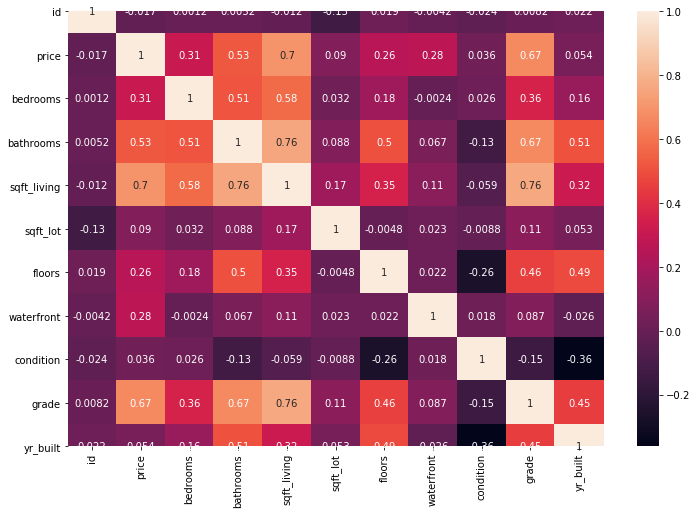

In [10]:
# remove unwanted columns
drop_vars = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated',
             'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
df_corr = df.drop(columns=drop_vars)

# generate heatmap to display correlations
corr = df_corr.corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot=True);

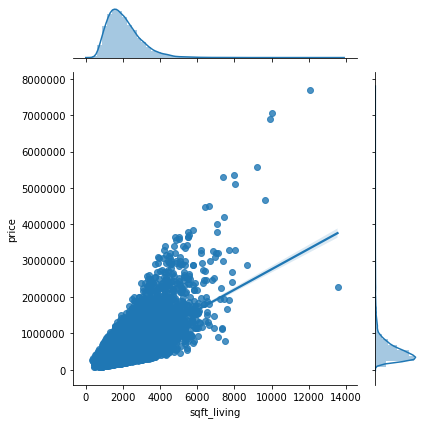

In [11]:
# examining the relationship between sqft_living and price
sns.jointplot('sqft_living','price', data=df, kind='reg')
plt.tight_layout()
plt.savefig('./visualizations/sqft_reg.png');

The visualization above demonstrates that there seems to be a relatively strong linear relationship between square feet of living space and the price of a house.

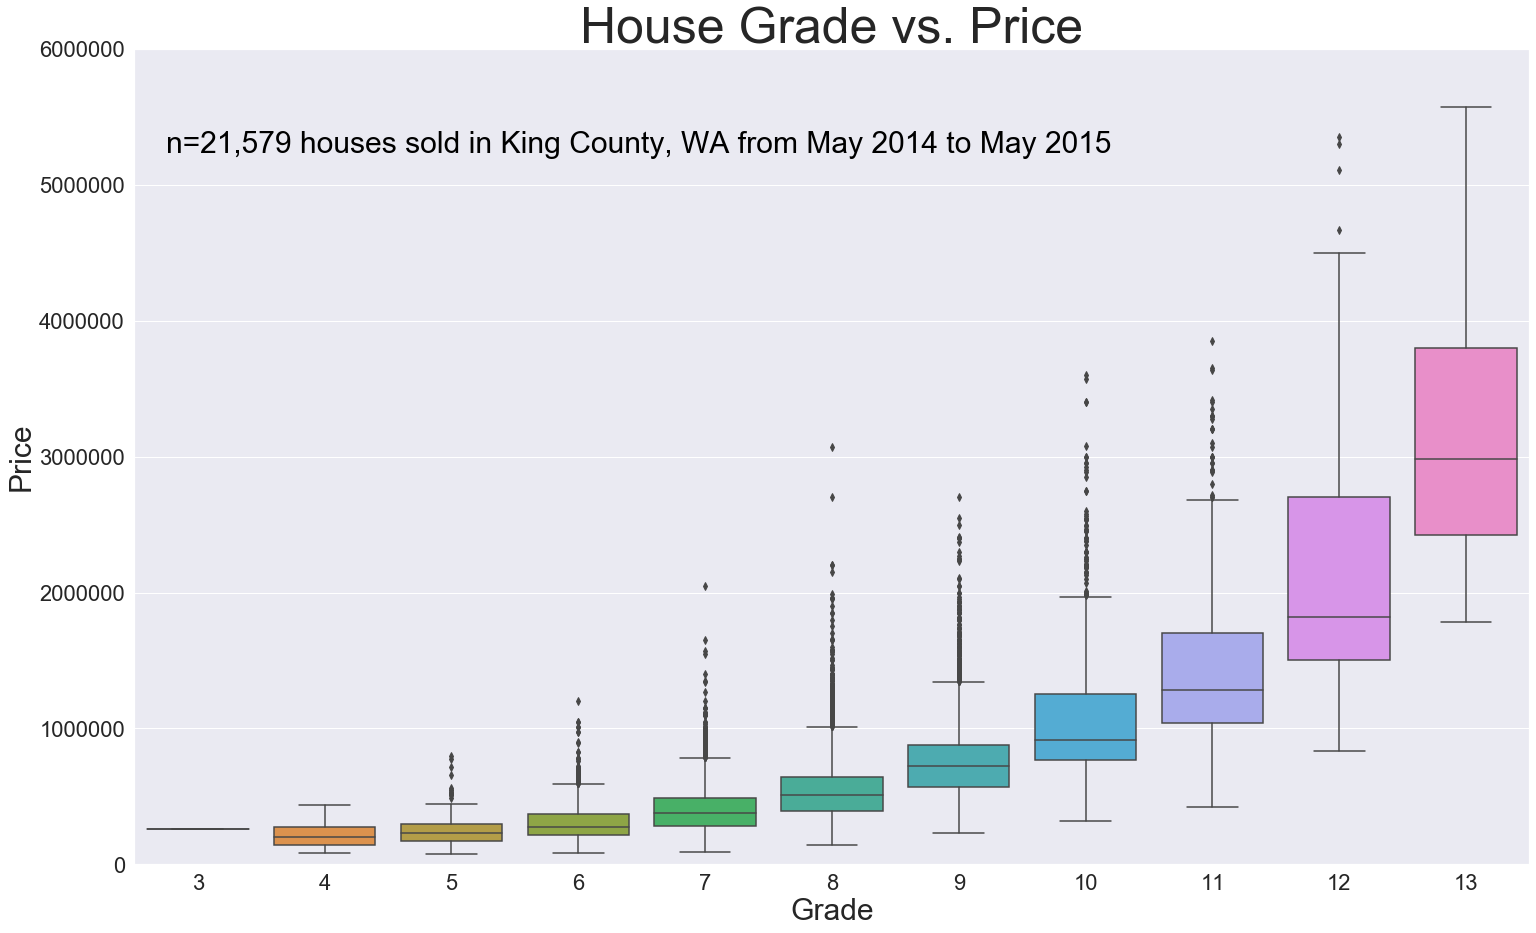

In [12]:
#grade
plt.figure(figsize=(25,15))
sns.set(font_scale=2)
pal = sns.color_palette("husl", 8)
ax = sns.boxplot(x="grade", y="price", data=df)
ax.set_title('House Grade vs. Price', fontsize=50)
ax.set_ylabel('Price', fontsize=30)
ax.set_xlabel('Grade', fontsize=30)
ax.set_ylim(bottom=0, top=6000000)
ax.text(.7, .9, 'n=21,579 houses sold in King County, WA from May 2014 to May 2015',
        color='black', fontsize=30,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes);
plt.savefig('./visualizations/grade.png');

When we look at grade, we can see that as the categorical building grade designation improves, the house price does indeed rise as well. This makes sense, as the definition for a building grade of 13 is, "Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc." We can see in the boxplots above that the mean house price for a home with a grade of 13 is far above even the max value for any other grade. In contrast, the definition of a building grade of 3 is, "Falls short of minimum building standards. Normally cabin or inferior structure." We can see this clearly demonstrated in the selling prices of houses on the lower end of grade.

In [13]:
df.grade.value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

The most common building grade is a 7, which is defined as, "Average grade of construction and design."

### Urban Institute Education Data

#### King County Schools
We began by calculcating the distance from each home to a school, to see if there was a connection between school proximity and house price.

In [14]:
# loading and previewing school data
schools = pd.read_csv('data/EducationDataPortal_11.22.2020_schools.csv')
schools.head()

year       ncessch                     school_name  state_name  \
0  2015  530000100376        Black Diamond Elementary  Washington   
1  2015  530000100377  Byron Kibler Elementary School  Washington   
2  2015  530000100379         Enumclaw Sr High School  Washington   
3  2015  530000100382     Southwood Elementary School  Washington   
4  2015  530000100383      Westwood Elementary School  Washington   

                   lea_name zip_location  latitude  longitude  county_code  \
0  Enumclaw School District        98010     47.31    -122.00     53033.00   
1  Enumclaw School District        98022     47.21    -122.00     53033.00   
2  Enumclaw School District        98022     47.19    -122.01     53033.00   
3  Enumclaw School District        98022     47.19    -122.01     53033.00   
4  Enumclaw School District        98022     47.23    -122.06     53033.00   

  school_level     school_type  
0      Primary  Regular school  
1      Primary  Regular school  
2         High  Regular school  
3      Primary  Regular school  
4      Primary  Regular school

In [15]:
# getting value counts for school county codes
schools.county_code.value_counts()

53033.00    518
53053.00    284
53061.00    223
53063.00    175
53011.00    135
53077.00    113
53035.00     80
53067.00     79
53073.00     69
53005.00     61
53025.00     55
53015.00     48
53057.00     48
53041.00     46
53065.00     42
53027.00     41
53007.00     39
53021.00     36
53047.00     33
53071.00     30
53009.00     29
53029.00     26
53075.00     26
53039.00     22
53045.00     22
53017.00     21
53037.00     20
53049.00     20
53043.00     16
53031.00     15
53001.00     15
53055.00     14
53019.00     12
53003.00     12
53059.00     11
53051.00      9
53013.00      4
53023.00      2
53069.00      2
Name: county_code, dtype: int64

In [16]:
# filtering dataframe to show only King County schools
# King County's county code is 53033 as per county website
schools = schools.loc[schools['county_code']==53033]
schools.head()

year       ncessch                     school_name  state_name  \
0  2015  530000100376        Black Diamond Elementary  Washington   
1  2015  530000100377  Byron Kibler Elementary School  Washington   
2  2015  530000100379         Enumclaw Sr High School  Washington   
3  2015  530000100382     Southwood Elementary School  Washington   
4  2015  530000100383      Westwood Elementary School  Washington   

                   lea_name zip_location  latitude  longitude  county_code  \
0  Enumclaw School District        98010     47.31    -122.00     53033.00   
1  Enumclaw School District        98022     47.21    -122.00     53033.00   
2  Enumclaw School District        98022     47.19    -122.01     53033.00   
3  Enumclaw School District        98022     47.19    -122.01     53033.00   
4  Enumclaw School District        98022     47.23    -122.06     53033.00   

  school_level     school_type  
0      Primary  Regular school  
1      Primary  Regular school  
2         High  Regular school  
3      Primary  Regular school  
4      Primary  Regular school

In [17]:
schools.shape

(518, 11)

In [18]:
# resetting index after filtering
schools.reset_index(inplace=True)
schools.head()

index  year       ncessch                     school_name  state_name  \
0      0  2015  530000100376        Black Diamond Elementary  Washington   
1      1  2015  530000100377  Byron Kibler Elementary School  Washington   
2      2  2015  530000100379         Enumclaw Sr High School  Washington   
3      3  2015  530000100382     Southwood Elementary School  Washington   
4      4  2015  530000100383      Westwood Elementary School  Washington   

                   lea_name zip_location  latitude  longitude  county_code  \
0  Enumclaw School District        98010     47.31    -122.00     53033.00   
1  Enumclaw School District        98022     47.21    -122.00     53033.00   
2  Enumclaw School District        98022     47.19    -122.01     53033.00   
3  Enumclaw School District        98022     47.19    -122.01     53033.00   
4  Enumclaw School District        98022     47.23    -122.06     53033.00   

  school_level     school_type  
0      Primary  Regular school  
1      Primary  Regular school  
2         High  Regular school  
3      Primary  Regular school  
4      Primary  Regular school

In [19]:
# dropping extra index column
schools.drop(columns='index', inplace=True, axis=1)

In [20]:
schools.head()

year       ncessch                     school_name  state_name  \
0  2015  530000100376        Black Diamond Elementary  Washington   
1  2015  530000100377  Byron Kibler Elementary School  Washington   
2  2015  530000100379         Enumclaw Sr High School  Washington   
3  2015  530000100382     Southwood Elementary School  Washington   
4  2015  530000100383      Westwood Elementary School  Washington   

                   lea_name zip_location  latitude  longitude  county_code  \
0  Enumclaw School District        98010     47.31    -122.00     53033.00   
1  Enumclaw School District        98022     47.21    -122.00     53033.00   
2  Enumclaw School District        98022     47.19    -122.01     53033.00   
3  Enumclaw School District        98022     47.19    -122.01     53033.00   
4  Enumclaw School District        98022     47.23    -122.06     53033.00   

  school_level     school_type  
0      Primary  Regular school  
1      Primary  Regular school  
2         High  Regular school  
3      Primary  Regular school  
4      Primary  Regular school

In [21]:
# checking for duplicates
schools.school_name.duplicated().sum()

11

In [22]:
# showing duplicates for school name
schools.loc[schools.school_name.duplicated()==True]

year       ncessch                     school_name  state_name  \
28   2015  530030002904               Special Ed School  Washington   
123  2015  530354000522           Cascade Middle School  Washington   
125  2015  530354000524           Chinook Middle School  Washington   
160  2015  530354003373              Gateway to College  Washington   
203  2015  530396000628  Panther Lake Elementary School  Washington   
321  2015  530591001993              Sunrise Elementary  Washington   
333  2015  530723001071     Hazelwood Elementary School  Washington   
337  2015  530723001076     Lakeridge Elementary School  Washington   
411  2015  530771001229  Olympic View Elementary School  Washington   
456  2015  530771003361  Rainier View Elementary School  Washington   
482  2015  530792003445                      Head Start  Washington   

                       lea_name zip_location  latitude  longitude  \
28       Auburn School District        98002     47.31    -122.22   
123    Highline School District        98146     47.50    -122.35   
125    Highline School District        98188     47.44    -122.28   
160    Highline School District        98146     47.50    -122.34   
203        Kent School District        98031     47.41    -122.20   
321  Northshore School District        98052     47.73    -122.11   
333      Renton School District        98056     47.54    -122.18   
337      Renton School District        98178     47.50    -122.24   
411      Seattle Public Schools        98115     47.70    -122.32   
456      Seattle Public Schools        98178     47.50    -122.26   
482   Shoreline School District        98133     47.75    -122.34   

     county_code school_level               school_type  
28      53033.00        Other  Special education school  
123     53033.00       Middle            Regular school  
125     53033.00       Middle            Regular school  
160     53033.00         High  Other/alternative school  
203     53033.00      Primary            Regular school  
321     53033.00      Primary            Regular school  
333     53033.00      Primary            Regular school  
337     53033.00      Primary            Regular school  
411     53033.00      Primary            Regular school  
456     53033.00      Primary            Regular school  
482     53033.00      Primary            Regular school

In [23]:
# reviewing duplicates
schools.loc[schools.school_name=='Panther Lake Elementary School']

year       ncessch                     school_name  state_name  \
99   2015  530282001767  Panther Lake Elementary School  Washington   
203  2015  530396000628  Panther Lake Elementary School  Washington   

                        lea_name zip_location  latitude  longitude  \
99   Federal Way School District        98003     47.29    -122.33   
203         Kent School District        98031     47.41    -122.20   

     county_code school_level     school_type  
99      53033.00      Primary  Regular school  
203     53033.00      Primary  Regular school

In [24]:
schools.loc[schools.school_name=='Cascade Middle School']

year       ncessch            school_name  state_name  \
12   2015  530030000033  Cascade Middle School  Washington   
123  2015  530354000522  Cascade Middle School  Washington   

                     lea_name zip_location  latitude  longitude  county_code  \
12     Auburn School District        98002     47.33    -122.21     53033.00   
123  Highline School District        98146     47.50    -122.35     53033.00   

    school_level     school_type  
12        Middle  Regular school  
123       Middle  Regular school

In [25]:
schools.loc[schools.school_name=='Sunrise Elementary']

year       ncessch         school_name  state_name  \
5    2015  530000100478  Sunrise Elementary  Washington   
321  2015  530591001993  Sunrise Elementary  Washington   

                       lea_name zip_location  latitude  longitude  \
5      Enumclaw School District        98022     47.19    -122.01   
321  Northshore School District        98052     47.73    -122.11   

     county_code school_level     school_type  
5       53033.00      Primary  Regular school  
321     53033.00      Primary  Regular school

When reviewing the 11 duplicates for "school_name", it was apparent that these were not duplicate entries, but rather, different institutions with the same name in different school districts. 

In [26]:
# checking for null values
schools.isnull().sum()

year            0
ncessch         0
school_name     0
state_name      0
lea_name        0
zip_location    0
latitude        0
longitude       0
county_code     0
school_level    0
school_type     0
dtype: int64

In [27]:
school_coordinates = []
x = round(schools.latitude, 2)
y = round(schools.longitude, 2)
school_coordinates = list(zip(x,y))

In [28]:
def distance_to(point_of_interest):
    """ 
    Calculates distance between point of interest and a house.
  
    Takes in coordinates for point of interest as latitude and longitude.
    Calculates distance from each point in dataframe (df) to point of interest.
    Uses haversine formula to calculate distance and return as kilometers.
    Can set distances as new column of dataframe by using df['new_column']=distance_to(point_of_interest).
  
    Parameters: 
    point_of_interest (float): user input coordinates (latitude,longitude).
  
    Returns: 
    Distances in kilometers, using haversine formula. 
    
    """
    distance = df[['lat','long']].apply(lambda x: hs.haversine(x.tolist(), point_of_interest), axis=1)
    return distance

In [29]:
for i in range(len(school_coordinates)):
    df[f'school_{i}'] = distance_to(school_coordinates[i])

school_cols = []
for i in range(len(school_coordinates)):
    school_cols.append(f'school_{i}')
    df['closest_distance_to_school'] = df[school_cols].min(axis=1)

In [30]:
df.closest_distance_to_school.describe()

count   21597.00
mean        0.88
std         0.77
min         0.00
25%         0.47
50%         0.71
75%         1.06
max        26.95
Name: closest_distance_to_school, dtype: float64

The closest distance to a school is 0.00 km (house located at the exact same latitude and longitude as a school building). The farthest distance is 26.95 km.

Skewness: 6.218078338828554
Kurtosis: 108.62323888858803


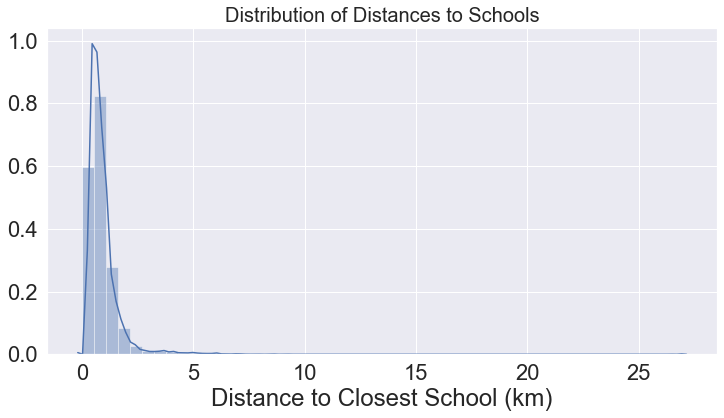

In [31]:
plt.figure(figsize=(12,6))
sns.distplot(df['closest_distance_to_school'])
plt.title("Distribution of Distances to Schools", fontsize=20)
plt.xlabel('Distance to Closest School (km)');
print("Skewness:", df['closest_distance_to_school'].skew())
print("Kurtosis:", df['closest_distance_to_school'].kurt())

In [32]:
plt.scatter(x=df['closest_distance_to_school'], y=df['price'])
plt.title('Relationship Between House Price and Distance to School')
plt.xlabel('Distance')
plt.ylabel('Price');

As expected, there seemed to be a negative correlation between distance to a school and the price of a house. As the distance between a house and a school decreased, the house price increased.

In [33]:
#dropping unnecessary columns
drop = ['date','id','yr_built', 'yr_renovated', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
df_cleaned = df.drop(columns = drop, axis=1)

In [34]:
df_cleaned = df_cleaned.drop(columns = school_cols, axis=1)

In [35]:
df_cleaned.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0 221900.00         3       1.00         1180      5650    1.00         nan   
1 538000.00         3       2.25         2570      7242    2.00        0.00   
2 180000.00         2       1.00          770     10000    1.00        0.00   
3 604000.00         4       3.00         1960      5000    1.00        0.00   
4 510000.00         3       2.00         1680      8080    1.00        0.00   

   view  condition  grade  zipcode   lat    long  closest_distance_to_school  
0  0.00          3      7    98178 47.51 -122.26                        0.26  
1  0.00          3      7    98125 47.72 -122.32                        0.68  
2  0.00          3      6    98028 47.74 -122.23                        0.32  
3  0.00          5      7    98136 47.52 -122.39                        1.73  
4  0.00          3      8    98074 47.62 -122.05                        1.18

In [36]:
df_cleaned.corr()

price  bedrooms  bathrooms  sqft_living  sqft_lot  \
price                        1.00      0.31       0.53         0.70      0.09   
bedrooms                     0.31      1.00       0.51         0.58      0.03   
bathrooms                    0.53      0.51       1.00         0.76      0.09   
sqft_living                  0.70      0.58       0.76         1.00      0.17   
sqft_lot                     0.09      0.03       0.09         0.17      1.00   
floors                       0.26      0.18       0.50         0.35     -0.00   
waterfront                   0.28     -0.00       0.07         0.11      0.02   
view                         0.40      0.08       0.19         0.28      0.08   
condition                    0.04      0.03      -0.13        -0.06     -0.01   
grade                        0.67      0.36       0.67         0.76      0.11   
zipcode                     -0.05     -0.15      -0.20        -0.20     -0.13   
lat                          0.31     -0.01       0.02         0.05     -0.09   
long                         0.02      0.13       0.22         0.24      0.23   
closest_distance_to_school   0.07      0.00       0.10         0.15      0.35   

                            floors  waterfront  view  condition  grade  \
price                         0.26        0.28  0.40       0.04   0.67   
bedrooms                      0.18       -0.00  0.08       0.03   0.36   
bathrooms                     0.50        0.07  0.19      -0.13   0.67   
sqft_living                   0.35        0.11  0.28      -0.06   0.76   
sqft_lot                     -0.00        0.02  0.08      -0.01   0.11   
floors                        1.00        0.02  0.03      -0.26   0.46   
waterfront                    0.02        1.00  0.41       0.02   0.09   
view                          0.03        0.41  1.00       0.05   0.25   
condition                    -0.26        0.02  0.05       1.00  -0.15   
grade                         0.46        0.09  0.25      -0.15   1.00   
zipcode                      -0.06        0.03  0.09       0.00  -0.19   
lat                           0.05       -0.01  0.01      -0.02   0.11   
long                          0.13       -0.04 -0.08      -0.11   0.20   
closest_distance_to_school    0.04        0.09  0.11      -0.03   0.12   

                            zipcode   lat  long  closest_distance_to_school  
price                         -0.05  0.31  0.02                        0.07  
bedrooms                      -0.15 -0.01  0.13                        0.00  
bathrooms                     -0.20  0.02  0.22                        0.10  
sqft_living                   -0.20  0.05  0.24                        0.15  
sqft_lot                      -0.13 -0.09  0.23                        0.35  
floors                        -0.06  0.05  0.13                        0.04  
waterfront                     0.03 -0.01 -0.04                        0.09  
view                           0.09  0.01 -0.08                        0.11  
condition                      0.00 -0.02 -0.11                       -0.03  
grade                         -0.19  0.11  0.20                        0.12  
zipcode                        1.00  0.27 -0.56                       -0.18  
lat                            0.27  1.00 -0.14                       -0.12  
long                          -0.56 -0.14  1.00                        0.33  
closest_distance_to_school    -0.18 -0.12  0.33                        1.00

In [37]:
df_cleaned = df_cleaned.loc[df_cleaned.closest_distance_to_school<20]

In [38]:
plt.scatter(x=df_cleaned['closest_distance_to_school'], y=df_cleaned['price'])
plt.title('Relationship Between House Price and Distance to School')
plt.xlabel('Distance')
plt.ylabel('Price');

With outliers removed, we are able to more clearly visualize this relationship.

In [39]:
df_cleaned.corr()

price  bedrooms  bathrooms  sqft_living  sqft_lot  \
price                        1.00      0.31       0.53         0.70      0.09   
bedrooms                     0.31      1.00       0.51         0.58      0.03   
bathrooms                    0.53      0.51       1.00         0.76      0.09   
sqft_living                  0.70      0.58       0.76         1.00      0.17   
sqft_lot                     0.09      0.03       0.09         0.17      1.00   
floors                       0.26      0.18       0.50         0.35     -0.00   
waterfront                   0.28     -0.00       0.07         0.11      0.02   
view                         0.40      0.08       0.19         0.28      0.08   
condition                    0.04      0.03      -0.13        -0.06     -0.01   
grade                        0.67      0.36       0.67         0.76      0.11   
zipcode                     -0.05     -0.15      -0.20        -0.20     -0.13   
lat                          0.31     -0.01       0.02         0.05     -0.09   
long                         0.02      0.13       0.22         0.24      0.23   
closest_distance_to_school   0.07      0.01       0.11         0.16      0.37   

                            floors  waterfront  view  condition  grade  \
price                         0.26        0.28  0.40       0.04   0.67   
bedrooms                      0.18       -0.00  0.08       0.03   0.36   
bathrooms                     0.50        0.07  0.19      -0.13   0.67   
sqft_living                   0.35        0.11  0.28      -0.06   0.76   
sqft_lot                     -0.00        0.02  0.08      -0.01   0.11   
floors                        1.00        0.02  0.03      -0.26   0.46   
waterfront                    0.02        1.00  0.41       0.02   0.09   
view                          0.03        0.41  1.00       0.05   0.25   
condition                    -0.26        0.02  0.05       1.00  -0.15   
grade                         0.46        0.09  0.25      -0.15   1.00   
zipcode                      -0.06        0.03  0.09       0.00  -0.19   
lat                           0.05       -0.01  0.01      -0.02   0.11   
long                          0.13       -0.04 -0.08      -0.11   0.20   
closest_distance_to_school    0.04        0.10  0.11      -0.03   0.13   

                            zipcode   lat  long  closest_distance_to_school  
price                         -0.05  0.31  0.02                        0.07  
bedrooms                      -0.15 -0.01  0.13                        0.01  
bathrooms                     -0.20  0.02  0.22                        0.11  
sqft_living                   -0.20  0.05  0.24                        0.16  
sqft_lot                      -0.13 -0.09  0.23                        0.37  
floors                        -0.06  0.05  0.13                        0.04  
waterfront                     0.03 -0.01 -0.04                        0.10  
view                           0.09  0.01 -0.08                        0.11  
condition                      0.00 -0.02 -0.11                       -0.03  
grade                         -0.19  0.11  0.20                        0.13  
zipcode                        1.00  0.27 -0.56                       -0.19  
lat                            0.27  1.00 -0.13                       -0.12  
long                          -0.56 -0.13  1.00                        0.33  
closest_distance_to_school    -0.19 -0.12  0.33                        1.00

#### King County Top Schools
There was only a correlation of 0.07 between proximity to a school and house price. So we narrowed this down to the top 8 school districts in King County, as per rankings on Niche.com, to see if there was a stronger correlation between house price and a highly ranked school.

In [40]:
schools.lea_name.value_counts()

Seattle Public Schools                          107
Lake Washington School District                  53
Federal Way School District                      48
Kent School District                             43
Highline School District                         43
Bellevue School District                         30
Renton School District                           29
Issaquah School District                         27
Auburn School District                           22
Northshore School District                       22
Shoreline School District                        19
Snoqualmie Valley School District                12
Enumclaw School District                          9
Riverview School District                         9
Tahoma School District                            9
Tukwila School District                           7
Vashon Island School District                     5
Mercer Island School District                     5
Mary Walker School District                       4
Lake Washing

In [41]:
from bs4 import BeautifulSoup
# url for Niche.com King County school district ranking
url = f"https://www.niche.com/k12/search/best-school-districts/c/king-county-wa/"
response = requests.get(url)
# creating soup
soup = BeautifulSoup(response.text, 'lxml')
soup.findAll('section')

[<section class="container"> <div class="customer-logo-wrapper"> <div class="customer-logo"> <img alt="Logo" src="http://a.niche.com/wp-content/themes/niche-about/images/about-home/stacked-green.svg"/> </div> </div> <div class="page-title-wrapper"> <div class="page-title"> <h1>Please verify you are a human</h1> </div> </div> <div class="content-wrapper"> <div class="content"> <div id="px-captcha"> </div> <p> Access to this page has been denied because we believe you are using automation tools to browse the website.  </p> <p> This may happen as a result of the following: </p> <ul> <li> Javascript is disabled or blocked by an extension (ad blockers for example) </li> <li> Your browser does not support cookies </li> </ul> <p> Please make sure that Javascript and cookies are enabled on your browser and that you are not blocking them from loading.  </p> <p> Reference ID: #fcdc0bf0-3e4f-11eb-b56d-b1d3df0409d6 </p> </div> </div> <div class="page-footer-wrapper"> <div class="page-footer"> <p> 

I attempted to web-scrape the data for the highest-ranked school districts in King County from Niche.com, but I was unable to do so due to being blocked by their server. So instead, I manually entered the eight school districts that were ranked in the A range (A+, A, A-) into a list.

In [42]:
top_schools = ['Mercer Island School District', 'Bellevue School District', 
              'Lake Washington School District', 'Issaquah School District',
              'Tahoma School District', 'Shoreline School District',
              'Vashon Island School District', 'Snoqualmie Valley School District',
              'Seattle Public Schools']

In [43]:
top_schools_df = schools.loc[schools['lea_name'].isin(top_schools)]
top_schools_df.head()

year       ncessch                     school_name  state_name  \
43  2015  530039000058       Ardmore Elementary School  Washington   
44  2015  530039000060            Bellevue High School  Washington   
45  2015  530039000062       Bennett Elementary School  Washington   
46  2015  530039000063  Cherry Crest Elementary School  Washington   
47  2015  530039000064           Chinook Middle School  Washington   

                    lea_name zip_location  latitude  longitude  county_code  \
43  Bellevue School District        98008     47.64    -122.12     53033.00   
44  Bellevue School District        98004     47.60    -122.20     53033.00   
45  Bellevue School District        98008     47.62    -122.10     53033.00   
46  Bellevue School District        98005     47.64    -122.17     53033.00   
47  Bellevue School District        98004     47.63    -122.21     53033.00   

   school_level     school_type  
43      Primary  Regular school  
44         High  Regular school  
45      Primary  Regular school  
46      Primary  Regular school  
47       Middle  Regular school

In [44]:
# saving copy of DataFrame as csv file
#top_schools_df.to_csv('./data/top_schools.csv')

In [45]:
top_school_coordinates = []
x = round(top_schools_df.latitude, 2)
y = round(top_schools_df.longitude, 2)
top_school_coordinates = list(zip(x,y))

In [46]:
for i in range(len(top_school_coordinates)):
    df[f'top_school_{i}'] = distance_to(top_school_coordinates[i])

top_school_cols = []
for i in range(len(top_school_coordinates)):
    top_school_cols.append(f'top_school_{i}')
    df['closest_distance_to_top_school'] = df[top_school_cols].min(axis=1)

In [47]:
df.closest_distance_to_top_school.describe()

count   21597.00
mean        3.09
std         4.41
min         0.00
25%         0.60
50%         1.05
75%         3.43
max        40.09
Name: closest_distance_to_top_school, dtype: float64

The closest distance from a house to a top school is 0.00 km (house located at the exact same latitude and longitude as a school building). The farthest distance is 40.09 km.

In [48]:
plt.figure(figsize=(12,6))
sns.distplot(df['closest_distance_to_top_school'])
plt.title("Distribution of Distances to Top Schools", fontsize=20)
plt.xlabel('Distance to Closest Top School (km)');
print("Skewness:", df['closest_distance_to_top_school'].skew())
print("Kurtosis:", df['closest_distance_to_top_school'].kurt())

Skewness: 2.2762581074960346
Kurtosis: 5.809128777092479


In [49]:
plt.scatter(x=df['closest_distance_to_top_school'], y=df['price'])
plt.title('Relationship Between House Price and Distance to Top School')
plt.xlabel('Distance')
plt.ylabel('Price');

In [50]:
#dropping unnecessary columns
drop = ['date','id','yr_built', 'yr_renovated', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
df_cleaned = df.drop(columns = drop, axis=1)

In [51]:
df_cleaned = df_cleaned.drop(columns = school_cols, axis=1)

In [52]:
df_cleaned = df_cleaned.drop(columns = top_school_cols, axis=1)

In [53]:
df_cleaned = df_cleaned.loc[df_cleaned.closest_distance_to_top_school<30]

In [54]:
plt.scatter(x=df_cleaned['closest_distance_to_top_school'], y=df_cleaned['price'])
plt.title('Relationship Between House Price and Distance to Top School')
plt.xlabel('Distance')
plt.ylabel('Price')
plt.savefig('./visualizations/school_price.png');

In [55]:
df_cleaned.corr()

price  bedrooms  bathrooms  sqft_living  \
price                            1.00      0.31       0.53         0.70   
bedrooms                         0.31      1.00       0.51         0.58   
bathrooms                        0.53      0.51       1.00         0.76   
sqft_living                      0.70      0.58       0.76         1.00   
sqft_lot                         0.09      0.03       0.09         0.17   
floors                           0.26      0.18       0.50         0.35   
waterfront                       0.28     -0.00       0.07         0.11   
view                             0.40      0.08       0.19         0.28   
condition                        0.04      0.03      -0.13        -0.06   
grade                            0.67      0.36       0.67         0.76   
zipcode                         -0.05     -0.16      -0.21        -0.20   
lat                              0.31     -0.01       0.03         0.05   
long                             0.03      0.14       0.23         0.25   
closest_distance_to_school       0.07      0.01       0.11         0.16   
closest_distance_to_top_school  -0.30     -0.00      -0.05        -0.06   

                                sqft_lot  floors  waterfront  view  condition  \
price                               0.09    0.26        0.28  0.40       0.04   
bedrooms                            0.03    0.18       -0.00  0.08       0.03   
bathrooms                           0.09    0.50        0.07  0.19      -0.13   
sqft_living                         0.17    0.35        0.11  0.28      -0.06   
sqft_lot                            1.00   -0.00        0.02  0.08      -0.01   
floors                             -0.00    1.00        0.02  0.03      -0.26   
waterfront                          0.02    0.02        1.00  0.41       0.02   
view                                0.08    0.03        0.41  1.00       0.05   
condition                          -0.01   -0.26        0.02  0.05       1.00   
grade                               0.11    0.46        0.09  0.25      -0.15   
zipcode                            -0.13   -0.06        0.03  0.09       0.00   
lat                                -0.09    0.05       -0.01  0.01      -0.01   
long                                0.23    0.13       -0.04 -0.08      -0.11   
closest_distance_to_school          0.36    0.04        0.10  0.11      -0.03   
closest_distance_to_top_school      0.11   -0.10        0.00 -0.02       0.01   

                                grade  zipcode   lat  long  \
price                            0.67    -0.05  0.31  0.03   
bedrooms                         0.36    -0.16 -0.01  0.14   
bathrooms                        0.67    -0.21  0.03  0.23   
sqft_living                      0.76    -0.20  0.05  0.25   
sqft_lot                         0.11    -0.13 -0.09  0.23   
floors                           0.46    -0.06  0.05  0.13   
waterfront                       0.09     0.03 -0.01 -0.04   
view                             0.25     0.09  0.01 -0.08   
condition                       -0.15     0.00 -0.01 -0.11   
grade                            1.00    -0.19  0.11  0.21   
zipcode                         -0.19     1.00  0.27 -0.57   
lat                              0.11     0.27  1.00 -0.14   
long                             0.21    -0.57 -0.14  1.00   
closest_distance_to_school       0.13    -0.19 -0.12  0.33   
closest_distance_to_top_school  -0.10    -0.29 -0.69 -0.00   

                                closest_distance_to_school  \
price                                                 0.07   
bedrooms                                              0.01   
bathrooms                                             0.11   
sqft_living                                           0.16   
sqft_lot                                              0.36   
floors                                                0.04   
waterfront                                            0.10   
view                                         

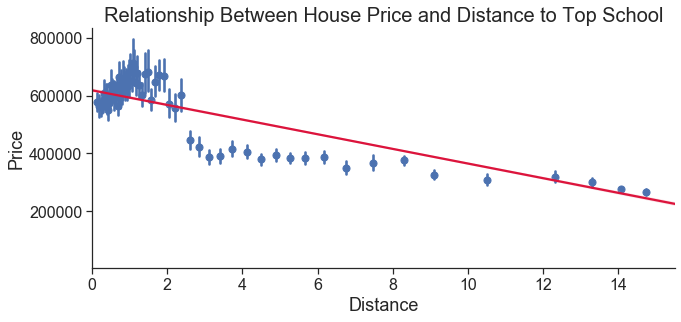

In [56]:
sns.set_style('ticks')
sns.lmplot(x='closest_distance_to_top_school', y='price', data=df_cleaned, aspect=2, line_kws={'color': 'crimson'}, x_bins=75)
plt.title('Relationship Between House Price and Distance to Top School', fontsize=20)
plt.xlabel('Distance', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);
#plt.ylim(100000,750000)
plt.xlim(0, 15.5);
plt.tight_layout()
plt.savefig('./visualizations/price_school_2.png')

When we look at the distance to a school and price, there is not much of a correlation there at all. However, once we narrow it down to the top schools, we start to see a stronger negative correlation. So as the distance to a top school decreases, the house price increases. 

### Proximity to Coffee Shops via Yelp API

We speculated that there may be a relationship between good coffee shops and higher home prices. We used the Yelp API to obtain the data for the top 50 highest-rated coffee shops and used the provided latitudes and longitudes to calculate their distances from each home.

In [57]:
import requests
import json

In [58]:
def get_keys(path):
    """Retrieves API key from files as api_key."""
    with open(path) as f:
        return json.load(f)

In [59]:
keys = get_keys("/Users/dtunnicliffe/.secret/yelp_api.json")
api_key = keys['api_key']

In [60]:
term = 'coffee'
location = 'King County, WA'
SEARCH_LIMIT = 50
mochas = pd.DataFrame([])
def yelp(term, location, SEARCH_LIMIT):
    """ 
    Creates a new dataframe of information retrieved from yelp API query.
  
    Searches businesses and returns top results based on criteria provided.
    Makes API call as if searching on yelp.
    Returns relevant information for businesses such as name, location, price range, and rating out of 5 stars.
  
    Parameters: 
    term (str): user input term to search for.
    location (str): user input city, state, or zip code to search within.
    SEARCH_LIMIT (int): user input number of results to return.
  
    Returns: 
    New dataframe populated with requested information. 
    
    """
    global mochas
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {
    'Authorization': f'Bearer {api_key}',
    }
    url_params = {
    'term': term.replace(' ', '+'),
    'location': location.replace(' ', '+'),
    'limit': SEARCH_LIMIT,
    'sort_by': 'rating'
    }
    response = requests.get(url, headers=headers, params=url_params)
    df_temp = pd.DataFrame.from_dict(response.json()['businesses'])
    mochas = mochas.append(df_temp)
    return mochas

In [61]:
mochas = yelp(term, location, SEARCH_LIMIT)

In [62]:
mochas.shape

(50, 16)

In [63]:
mochas.head()

id                                 alias  \
0  h1dhP2ZRiMGE2RdpUtputg             coffeeholic-house-seattle   
1  PJakGoM3gkStlwG5AvPadw               mighty-mugs-coffee-kent   
2  S6CXIQ5KrMpTPZf1eNMa2w    five-stones-coffee-company-redmond   
3  0ms-mWSw4ywRDM4Yn11r7g  lamppost-coffee-roasters-bonney-lake   
4  EWqgeiGor-aVJlMLc8iSKw              boon-boona-coffee-renton   

                         name  \
0           Coffeeholic House   
1          Mighty Mugs Coffee   
2  Five Stones Coffee Company   
3    Lamppost Coffee Roasters   
4           Boon Boona Coffee   

                                           image_url  is_closed  \
0  https://s3-media1.fl.yelpcdn.com/bphoto/m5L0vI...      False   
1  https://s3-media1.fl.yelpcdn.com/bphoto/xKBXSp...      False   
2  https://s3-media3.fl.yelpcdn.com/bphoto/OmzSO6...      False   
3  https://s3-media2.fl.yelpcdn.com/bphoto/d4pn9O...      False   
4  https://s3-media3.fl.yelpcdn.com/bphoto/tVH2Gx...      False   

                                                 url  review_count  \
0  https://www.yelp.com/biz/coffeeholic-house-sea...           254   
1  https://www.yelp.com/biz/mighty-mugs-coffee-ke...           102   
2  https://www.yelp.com/biz/five-stones-coffee-co...           415   
3  https://www.yelp.com/biz/lamppost-coffee-roast...            27   
4  https://www.yelp.com/biz/boon-boona-coffee-ren...           209   

                                          categories  rating  \
0     [{'alias': 'coffee', 'title': 'Coffee & Tea'}]    4.50   
1  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...    5.00   
2     [{'alias': 'coffee', 'title': 'Coffee & Tea'}]    4.50   
3  [{'alias': 'coffeeroasteries', 'title': 'Coffe...    5.00   
4  [{'alias': 'coffeeroasteries', 'title': 'Coffe...    4.50   

                                         coordinates        transactions  \
0    {'latitude': 47.55723, 'longitude': -122.28596}                  []   
1  {'latitude': 47.4408184523004, 'longitude': -1...                  []   
2    {'latitude': 47.67583, 'longitude': -122.12471}          [delivery]   
3  {'latitude': 47.167816, 'longitude': -122.1612...          [delivery]   
4  {'latitude': 47.4797895, 'longitude': -122.206...  [delivery, pickup]   

                                            location         phone  \
0  {'address1': '3700 S Hudson St', 'address2': N...  +12067223327   
1  {'address1': '18010 E Valley Hwy', 'address2':...  +14254401450   
2  {'address1': '8102 161st Ave NE', 'address2': ...  +14252420099   
3  {'address1': '20077 WA 410', 'address2': '', '...  +12538261146   
4  {'address1': '724 S 3rd St', 'address2': 'Ste ...  +14254968618   

    display_phone  distance price  
0  (206) 722-3327  39598.15   NaN  
1  (425) 440-1450  31990.48     $  
2  (425) 242-0099  37007.96    $$  
3  (253) 826-1146  40093.87   NaN  
4  (425) 496-8618  31528.44     $

In [64]:
coffee_coordinates = []
x = [round(coordinate['latitude'], 2) for coordinate in mochas['coordinates']]
y = [round(coordinate['longitude'], 2) for coordinate in mochas['coordinates']]
coffee_coordinates = list(zip(x,y))

In [65]:
for i in range(len(coffee_coordinates)):
    df_cleaned[f'coffee_{i}'] = distance_to(coffee_coordinates[i])

coffee_cols = []
for i in range(len(coffee_coordinates)):
    coffee_cols.append(f'coffee_{i}')
    df_cleaned['closest_distance_to_good_coffee'] = df_cleaned[coffee_cols].min(axis=1)

In [66]:
df_cleaned.closest_distance_to_good_coffee.describe()

count   21580.00
mean        5.39
std         3.46
min         0.03
25%         2.77
50%         4.79
75%         7.29
max        20.80
Name: closest_distance_to_good_coffee, dtype: float64

The closest distance to a highly rated coffee shop is 0.03 km. The farthest distance is 22.89 km.

In [67]:
plt.figure(figsize=(12,6))
sns.distplot(df_cleaned['closest_distance_to_good_coffee'])
plt.title("Distribution of Distances to Highly Rated Coffee Shops", fontsize=20)
plt.xlabel('Distance to Closest Highly Rated Coffe (km)');
print("Skewness:", df_cleaned['closest_distance_to_good_coffee'].skew())
print("Kurtosis:", df_cleaned['closest_distance_to_good_coffee'].kurt())

Skewness: 0.9710209137999876
Kurtosis: 0.8312576020439337


In [68]:
plt.scatter(x=df_cleaned['closest_distance_to_good_coffee'], y=df_cleaned['price'])
plt.title('Relationship Between House Price and Distance to Highly Rated Coffee')
plt.xlabel('Distance')
plt.ylabel('Price');

In [69]:
#dropping unnecessary columns
df_cleaned = df_cleaned.drop(columns = coffee_cols, axis=1)
df_cleaned.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0 221900.00         3       1.00         1180      5650    1.00         nan   
1 538000.00         3       2.25         2570      7242    2.00        0.00   
2 180000.00         2       1.00          770     10000    1.00        0.00   
3 604000.00         4       3.00         1960      5000    1.00        0.00   
4 510000.00         3       2.00         1680      8080    1.00        0.00   

   view  condition  grade  zipcode   lat    long  closest_distance_to_school  \
0  0.00          3      7    98178 47.51 -122.26                        0.26   
1  0.00          3      7    98125 47.72 -122.32                        0.68   
2  0.00          3      6    98028 47.74 -122.23                        0.32   
3  0.00          5      7    98136 47.52 -122.39                        1.73   
4  0.00          3      8    98074 47.62 -122.05                        1.18   

   closest_distance_to_top_school  closest_distance_to_good_coffee  
0                            0.26                             4.39  
1                            0.68                            10.38  
2                            2.00                            10.63  
3                            1.73                             8.88  
4                            1.18                             8.00

In [70]:
optimal = df_cleaned.loc[(df_cleaned['price']>180000) & (df_cleaned['price']<700000)]
optimal.corr()

price  bedrooms  bathrooms  sqft_living  \
price                             1.00      0.19       0.32         0.44   
bedrooms                          0.19      1.00       0.46         0.59   
bathrooms                         0.32      0.46       1.00         0.67   
sqft_living                       0.44      0.59       0.67         1.00   
sqft_lot                          0.07      0.02       0.03         0.14   
floors                            0.21      0.11       0.49         0.28   
waterfront                        0.03     -0.04      -0.04        -0.02   
view                              0.14      0.01       0.04         0.10   
condition                         0.01      0.02      -0.16        -0.08   
grade                             0.47      0.26       0.56         0.60   
zipcode                           0.03     -0.16      -0.23        -0.23   
lat                               0.47     -0.10      -0.10        -0.13   
long                              0.07      0.14       0.24         0.28   
closest_distance_to_school        0.06     -0.00       0.08         0.14   
closest_distance_to_top_school   -0.42      0.09       0.07         0.12   
closest_distance_to_good_coffee  -0.01     -0.04      -0.11        -0.05   

                                 sqft_lot  floors  waterfront  view  \
price                                0.07    0.21        0.03  0.14   
bedrooms                             0.02    0.11       -0.04  0.01   
bathrooms                            0.03    0.49       -0.04  0.04   
sqft_living                          0.14    0.28       -0.02  0.10   
sqft_lot                             1.00   -0.05        0.02  0.10   
floors                              -0.05    1.00       -0.02 -0.03   
waterfront                           0.02   -0.02        1.00  0.29   
view                                 0.10   -0.03        0.29  1.00   
condition                            0.01   -0.29        0.01  0.02   
grade                                0.04    0.43       -0.03  0.07   
zipcode                             -0.14   -0.06        0.02  0.09   
lat                                 -0.11   -0.01       -0.04 -0.07   
long                                 0.22    0.11       -0.06 -0.07   
closest_distance_to_school           0.39    0.02        0.12  0.12   
closest_distance_to_top_school       0.13   -0.05        0.03  0.07   
closest_distance_to_good_coffee      0.01   -0.13        0.09  0.06   

                                 condition  grade  zipcode   lat  long  \
price                                 0.01   0.47     0.03  0.47  0.07   
bedrooms                              0.02   0.26    -0.16 -0.10  0.14   
bathrooms                            -0.16   0.56    -0.23 -0.10  0.24   
sqft_living                          -0.08   0.60    -0.23 -0.13  0.28   
sqft_lot                              0.01   0.04    -0.14 -0.11  0.22   
floors                               -0.29   0.43    -0.06 -0.01  0.11   
waterfront                            0.01  -0.03     0.02 -0.04 -0.06   
view                                  0.02   0.07     0.09 -0.07 -0.07   
condition                             1.00  -0.20    -0.01 -0.03 -0.07   
grade                                -0.20   1.00    -0.19 -0.02  0.20   
zipcode                              -0.01  -0.19     1.00  0.31 -0.56   
lat                                  -0.03  -0.02     0.31  1.00 -0.16   
long                                 -0.07   0.20    -0.56 -0.16  1.00   
closest_distance_to_school           -0.01   0.09    -0.18 -0.13  0.32   
closest_distance_to_top_school        0.02   0.04    -0.35 -0.69 -0.00   
closest_distance_to_good_coffee       0.02  -0.04     0.32  0.36 -0.49   

                                 closest_distance_to_school  \
price                                                  0.06   
bedrooms                                              -0.00   
bathrooms                                              0.08   
sqft_living          

Unfortunately, there was no observable relationship between house price and distance to a highly rated coffee shop.

### Top 10 Highest-Rated Coffee Shops from Yelp API

We then gathered data for the top 10 highest-rated coffee shops in King County, as per the Yelp API, and tried to find a connection between house price and distance from a very highly-rated coffee shop.

In [71]:
term = 'coffee'
location = 'King County, WA'
SEARCH_LIMIT = 10
espresso = pd.DataFrame([])
def yelp(term, location, SEARCH_LIMIT):
    """ 
    Creates a new dataframe of information retrieved from yelp API query.
  
    Searches businesses and returns top results based on criteria provided.
    Makes API call as if searching on yelp.
    Returns relevant information for businesses such as name, location, price range, and rating out of 5 stars.
  
    Parameters: 
    term (str): user input term to search for.
    location (str): user input city, state, or zip code to search within.
    SEARCH_LIMIT (int): user input number of results to return.
  
    Returns: 
    New dataframe populated with requested information. 
    
    """
    global espresso
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {
    'Authorization': f'Bearer {api_key}',
    }
    url_params = {
    'term': term.replace(' ', '+'),
    'location': location.replace(' ', '+'),
    'limit': SEARCH_LIMIT,
    'sort_by': 'rating'
    }
    response = requests.get(url, headers=headers, params=url_params)
    df_temp = pd.DataFrame.from_dict(response.json()['businesses'])
    espresso = espresso.append(df_temp)
    return espresso

In [72]:
espresso = yelp(term, location, SEARCH_LIMIT)

In [73]:
espresso.shape

(10, 16)

In [74]:
espresso.head(10)

id                                 alias  \
0  S6CXIQ5KrMpTPZf1eNMa2w    five-stones-coffee-company-redmond   
1  v7xfqk9f7N8A98AQ2kddWg          anchorhead-coffee-bellevue-3   
2  t2DOOFh-oJLddtpxbVlDrQ           huxdotter-coffee-north-bend   
3  -MzbuOLr2kAoqlQY8w7ECA  pioneer-coffee-north-bend-north-bend   
4  oUk6IZAFQ37R5OK0etWocg      the-north-bend-bakery-north-bend   
5  9DJY3ndAM0E6T7qGtrq0kg      issaquah-coffee-company-issaquah   
6  kybVpzGFcYov1d0X00vDjQ                  candor-coffee-renton   
7  9yDshpKSd3mjYs2JUY5JbQ                 espresso-chalet-index   
8  Abtd76-NMG-MNlaOklCxMg            the-bindlestick-snoqualmie   
9  U0zB-UuDQCYZWilcG_ju7A                 cafe-minee-snoqualmie   

                          name  \
0   Five Stones Coffee Company   
1            Anchorhead Coffee   
2             Huxdotter Coffee   
3  Pioneer Coffee - North Bend   
4        The North Bend Bakery   
5      Issaquah Coffee Company   
6                Candor Coffee   
7              Espresso Chalet   
8              The Bindlestick   
9                   Cafe Minee   

                                           image_url  is_closed  \
0  https://s3-media3.fl.yelpcdn.com/bphoto/OmzSO6...      False   
1  https://s3-media3.fl.yelpcdn.com/bphoto/ErNP7S...      False   
2  https://s3-media3.fl.yelpcdn.com/bphoto/MdLMtc...      False   
3  https://s3-media3.fl.yelpcdn.com/bphoto/5SpY3i...      False   
4  https://s3-media1.fl.yelpcdn.com/bphoto/weMpOC...      False   
5  https://s3-media4.fl.yelpcdn.com/bphoto/PDXXmy...      False   
6  https://s3-media4.fl.yelpcdn.com/bphoto/NUupoy...      False   
7  https://s3-media1.fl.yelpcdn.com/bphoto/vkm9Vg...      False   
8  https://s3-media1.fl.yelpcdn.com/bphoto/bpncBp...      False   
9  https://s3-media4.fl.yelpcdn.com/bphoto/YQdJgn...      False   

                                                 url  review_count  \
0  https://www.yelp.com/biz/five-stones-coffee-co...           415   
1  https://www.yelp.com/biz/anchorhead-coffee-bel...            70   
2  https://www.yelp.com/biz/huxdotter-coffee-nort...            83   
3  https://www.yelp.com/biz/pioneer-coffee-north-...            75   
4  https://www.yelp.com/biz/the-north-bend-bakery...           158   
5  https://www.yelp.com/biz/issaquah-coffee-compa...           355   
6  https://www.yelp.com/biz/candor-coffee-renton?...            20   
7  https://www.yelp.com/biz/espresso-chalet-index...            65   
8  https://www.yelp.com/biz/the-bindlestick-snoqu...            64   
9  https://www.yelp.com/biz/cafe-minee-snoqualmie...            64   

                                          categories  rating  \
0     [{'alias': 'coffee', 'title': 'Coffee & Tea'}]    4.50   
1  [{'alias': 'coffeeroasteries', 'title': 'Coffe...    4.50   
2  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...    4.50   
3  [{'alias': 'coffeeroasteries', 'title': 'Coffe...    4.50   
4  [{'alias': 'bakeries', 'title': 'Bakeries'}, {...    4.00   
5  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...    4.00   
6  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...    4.50   
7     [{'alias': 'coffee', 'title': 'Coffee & Tea'}]    4.00   
8  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...    4.00   
9  [{'alias': 'bakeries', 'title': 'Bakeries'}, {...    4.00   

                                         coordinates transactions price  \
0    {'latitude': 47.67583, 'longitude': -122.12471}   [delivery]    $$   
1   {'latitude': 47.61509, 'longitude': -122.194026}   [delivery]   NaN   
2  {'latitude': 47.493445, 'longitude': -121.787556}           []     $   
3  {'latitude': 47.4956976441376, 'longitude': -1...           []     $   
4  {'latitude': 47.4950561, 'longitude': -121.786...           []     $   
5  {'latitude': 47.5396224396688, 'longitude': -1...   [delivery]     $   
6  {'latitude': 47.441603, 'longitude': -122.220055}           []   NaN   
7  {'latitude': 47.8085589918289, 'longitude': -1...           []     $   
8    {'latitude': 47.

In [75]:
great_coffee_coordinates = []
x = [round(coordinate['latitude'], 2) for coordinate in espresso['coordinates']]
y = [round(coordinate['longitude'], 2) for coordinate in espresso['coordinates']]
great_coffee_coordinates = list(zip(x,y))

In [76]:
for i in range(len(great_coffee_coordinates)):
    df_cleaned[f'great_coffee_{i}'] = distance_to(great_coffee_coordinates[i])

great_coffee_cols = []
for i in range(len(great_coffee_coordinates)):
    great_coffee_cols.append(f'great_coffee_{i}')
    df_cleaned['closest_distance_to_great_coffee'] = df_cleaned[great_coffee_cols].min(axis=1)

In [77]:
df_cleaned.closest_distance_to_great_coffee.describe()

count   21580.00
mean       10.60
std         5.32
min         0.09
25%         6.66
50%         9.94
75%        14.71
max        36.98
Name: closest_distance_to_great_coffee, dtype: float64

The closest distance to a very highly rated coffee shop is 0.09 km. The farthest distance is 39.19 km.

Skewness: 0.5729380397094243
Kurtosis: 0.7979295440671059


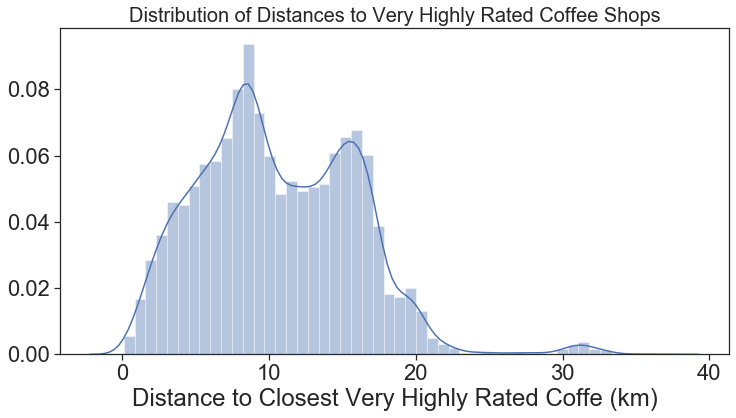

In [78]:
plt.figure(figsize=(12,6))
sns.distplot(df_cleaned['closest_distance_to_great_coffee'])
plt.title("Distribution of Distances to Very Highly Rated Coffee Shops", fontsize=20)
plt.xlabel('Distance to Closest Very Highly Rated Coffe (km)');
print("Skewness:", df_cleaned['closest_distance_to_great_coffee'].skew())
print("Kurtosis:", df_cleaned['closest_distance_to_great_coffee'].kurt())

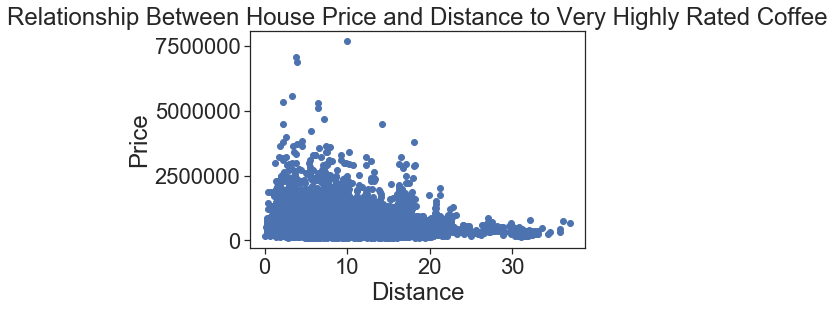

In [79]:
plt.scatter(x=df_cleaned['closest_distance_to_great_coffee'], y=df_cleaned['price'])
plt.title('Relationship Between House Price and Distance to Very Highly Rated Coffee')
plt.xlabel('Distance')
plt.ylabel('Price');

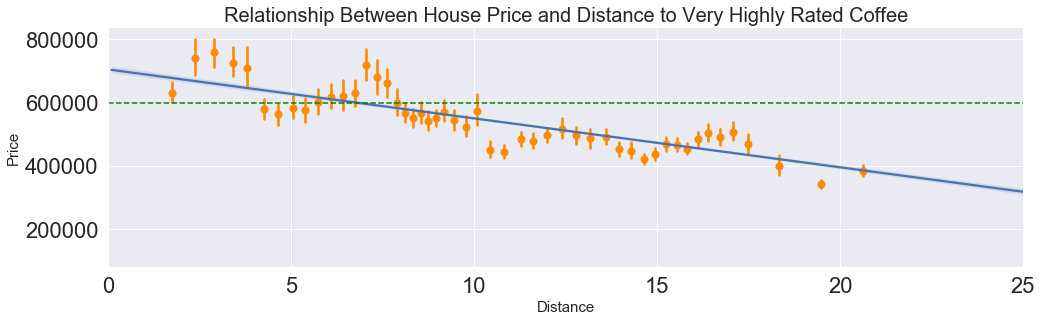

In [80]:
# plotting house price by distance to highly rated coffee
sns.set_style('darkgrid')
sns.lmplot(x='closest_distance_to_great_coffee', y='price', data=df_cleaned, aspect=3, x_bins=50, scatter_kws={'color': 'darkorange'})
plt.title('Relationship Between House Price and Distance to Very Highly Rated Coffee', fontsize=20)
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xlim(0, 25)
plt.axhline(y=600000, ls='--', c='green');
plt.tight_layout()
plt.savefig('./visualizations/price_coffee_2.png')

In [81]:
#dropping unnecessary columns
df_cleaned = df_cleaned.drop(columns = great_coffee_cols, axis=1)
df_cleaned.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0 221900.00         3       1.00         1180      5650    1.00         nan   
1 538000.00         3       2.25         2570      7242    2.00        0.00   
2 180000.00         2       1.00          770     10000    1.00        0.00   
3 604000.00         4       3.00         1960      5000    1.00        0.00   
4 510000.00         3       2.00         1680      8080    1.00        0.00   

   view  condition  grade  zipcode   lat    long  closest_distance_to_school  \
0  0.00          3      7    98178 47.51 -122.26                        0.26   
1  0.00          3      7    98125 47.72 -122.32                        0.68   
2  0.00          3      6    98028 47.74 -122.23                        0.32   
3  0.00          5      7    98136 47.52 -122.39                        1.73   
4  0.00          3      8    98074 47.62 -122.05                        1.18   

   closest_distance_to_top_school  closest_distance_to_good_coffee  \
0                            0.26                             4.39   
1                            0.68                            10.38   
2                            2.00                            10.63   
3                            1.73                             8.88   
4                            1.18                             8.00   

   closest_distance_to_great_coffee  
0                              8.39  
1                             14.81  
2                             10.63  
3                             15.80  
4                              8.55

In [82]:
df_cleaned.corr()

price  bedrooms  bathrooms  sqft_living  \
price                              1.00      0.31       0.53         0.70   
bedrooms                           0.31      1.00       0.51         0.58   
bathrooms                          0.53      0.51       1.00         0.76   
sqft_living                        0.70      0.58       0.76         1.00   
sqft_lot                           0.09      0.03       0.09         0.17   
floors                             0.26      0.18       0.50         0.35   
waterfront                         0.28     -0.00       0.07         0.11   
view                               0.40      0.08       0.19         0.28   
condition                          0.04      0.03      -0.13        -0.06   
grade                              0.67      0.36       0.67         0.76   
zipcode                           -0.05     -0.16      -0.21        -0.20   
lat                                0.31     -0.01       0.03         0.05   
long                               0.03      0.14       0.23         0.25   
closest_distance_to_school         0.07      0.01       0.11         0.16   
closest_distance_to_top_school    -0.30     -0.00      -0.05        -0.06   
closest_distance_to_good_coffee   -0.10     -0.06      -0.12        -0.09   
closest_distance_to_great_coffee  -0.22     -0.15      -0.17        -0.21   

                                  sqft_lot  floors  waterfront  view  \
price                                 0.09    0.26        0.28  0.40   
bedrooms                              0.03    0.18       -0.00  0.08   
bathrooms                             0.09    0.50        0.07  0.19   
sqft_living                           0.17    0.35        0.11  0.28   
sqft_lot                              1.00   -0.00        0.02  0.08   
floors                               -0.00    1.00        0.02  0.03   
waterfront                            0.02    0.02        1.00  0.41   
view                                  0.08    0.03        0.41  1.00   
condition                            -0.01   -0.26        0.02  0.05   
grade                                 0.11    0.46        0.09  0.25   
zipcode                              -0.13   -0.06        0.03  0.09   
lat                                  -0.09    0.05       -0.01  0.01   
long                                  0.23    0.13       -0.04 -0.08   
closest_distance_to_school            0.36    0.04        0.10  0.11   
closest_distance_to_top_school        0.11   -0.10        0.00 -0.02   
closest_distance_to_good_coffee       0.01   -0.13        0.07  0.05   
closest_distance_to_great_coffee      0.06   -0.06        0.01  0.05   

                                  condition  grade  zipcode   lat  long  \
price                                  0.04   0.67    -0.05  0.31  0.03   
bedrooms                               0.03   0.36    -0.16 -0.01  0.14   
bathrooms                             -0.13   0.67    -0.21  0.03  0.23   
sqft_living                           -0.06   0.76    -0.20  0.05  0.25   
sqft_lot                              -0.01   0.11    -0.13 -0.09  0.23   
floors                                -0.26   0.46    -0.06  0.05  0.13   
waterfront                             0.02   0.09     0.03 -0.01 -0.04   
view                                   0.05   0.25     0.09  0.01 -0.08   
condition                              1.00  -0.15     0.00 -0.01 -0.11   
grade                                 -0.15   1.00    -0.19  0.11  0.21   
zipcode                                0.00  -0.19     1.00  0.27 -0.57   
lat                                   -0.01   0.11     0.27  1.00 -0.14   
long                                  -0.11   0.21    -0.57 -0.14  1.00   
closest_distance_to_school            -0.03   0.13    -0.19 -0.12  0.33   
closest_distance_to_top_school         0.01  -0.10    -0.29 -0.69 -0.00   
closest_distance_to_good_coffee        0.00  -0.09     0.33  0.30 -0.45   
closest_distance_to_great_coffee       0.05  -0.20     0.25 -0.18 -0.41   


We found that, similar to good schools, there was a negative correlation between house price and proximity to a very highly-rated coffee shop. As distance to a great coffee shop decreases, house price increases.

### Proximity to Scientology Churches

We had heard a theory that homes located near scientology churches tend to be higher in price, due to the fact that scientologists are known for investing funds in their surrounding communities. While certainly unique, we wanted to explore this feature and see if there was any connection between house price and proximity to a church of scientology.

In [83]:
#locations pulled from scientology-seattle.org
church_of_scientology_mission = (47.818100, -122.315430)
church_of_scientology_washington = (47.622380, -122.361020)
church_of_scientology_life_improvement_center = (47.615060, -122.327580)

In [84]:
# creating a dataframe to investigate scientology proximity
scientology = pd.read_csv('./data/kc_house_data.csv')

# creating new columns of distances from houses to scientology churches
# running our haversine calculator function on these points
scientology['distance_to_scientology_m'] = distance_to(church_of_scientology_mission)
scientology['distance_to_scientology_w'] = distance_to(church_of_scientology_washington)
scientology['distance_to_scientology_l'] = distance_to(church_of_scientology_life_improvement_center)
scientology['closest_distance_to_scientology'] = scientology[['distance_to_scientology_m',
                                                        'distance_to_scientology_w',
                                                        'distance_to_scientology_l']].min(axis=1)

Distribution appears to deviate slightly from a normal distribution.
Displays a positive skewness.
Skewness: 0.8119816020278896
Kurtosis: 0.1550669496730026


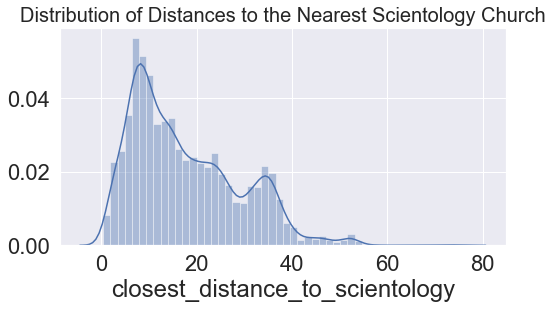

In [85]:
plt.figure(figsize=(8,4))
sns.distplot(scientology['closest_distance_to_scientology'])
plt.title("Distribution of Distances to the Nearest Scientology Church", fontsize=20);
print("Distribution appears to deviate slightly from a normal distribution.")
print("Displays a positive skewness.")
print("Skewness:", scientology['closest_distance_to_scientology'].skew())
print("Kurtosis:", scientology['closest_distance_to_scientology'].kurt())

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


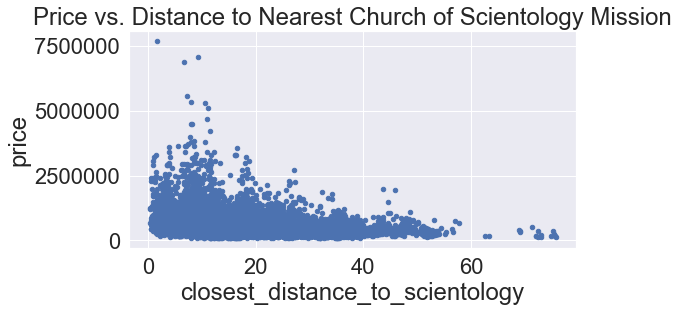

In [86]:
#church of scientology vs price plot
plot1 = pd.concat([scientology['price'], scientology['closest_distance_to_scientology']], axis=1)
plot1.plot.scatter(x='closest_distance_to_scientology', y='price', figsize=(8,4))
plt.title("Price vs. Distance to Nearest Church of Scientology Mission");

In [87]:
scientology.corr()

id  price  bedrooms  bathrooms  \
id                               1.00  -0.02      0.00       0.01   
price                           -0.02   1.00      0.31       0.53   
bedrooms                         0.00   0.31      1.00       0.51   
bathrooms                        0.01   0.53      0.51       1.00   
sqft_living                     -0.01   0.70      0.58       0.76   
sqft_lot                        -0.13   0.09      0.03       0.09   
floors                           0.02   0.26      0.18       0.50   
waterfront                      -0.00   0.28     -0.00       0.07   
view                             0.01   0.40      0.08       0.19   
condition                       -0.02   0.04      0.03      -0.13   
grade                            0.01   0.67      0.36       0.67   
sqft_above                      -0.01   0.61      0.48       0.69   
yr_built                         0.02   0.05      0.16       0.51   
yr_renovated                    -0.01   0.13      0.02       0.05   
zipcode                         -0.01  -0.05     -0.15      -0.20   
lat                             -0.00   0.31     -0.01       0.02   
long                             0.02   0.02      0.13       0.22   
sqft_living15                   -0.00   0.59      0.39       0.57   
sqft_lot15                      -0.14   0.08      0.03       0.09   
distance_to_scientology_m        0.01  -0.29      0.02       0.03   
distance_to_scientology_w        0.01  -0.28      0.07       0.09   
distance_to_scientology_l        0.00  -0.30      0.05       0.07   
closest_distance_to_scientology  0.01  -0.28      0.05       0.08   

                                 sqft_living  sqft_lot  floors  waterfront  \
id                                     -0.01     -0.13    0.02       -0.00   
price                                   0.70      0.09    0.26        0.28   
bedrooms                                0.58      0.03    0.18       -0.00   
bathrooms                               0.76      0.09    0.50        0.07   
sqft_living                             1.00      0.17    0.35        0.11   
sqft_lot                                0.17      1.00   -0.00        0.02   
floors                                  0.35     -0.00    1.00        0.02   
waterfront                              0.11      0.02    0.02        1.00   
view                                    0.28      0.08    0.03        0.41   
condition                              -0.06     -0.01   -0.26        0.02   
grade                                   0.76      0.11    0.46        0.09   
sqft_above                              0.88      0.18    0.52        0.08   
yr_built                                0.32      0.05    0.49       -0.03   
yr_renovated                            0.06      0.00    0.00        0.09   
zipcode                                -0.20     -0.13   -0.06        0.03   
lat                                     0.05     -0.09    0.05       -0.01   
long                                    0.24      0.23    0.13       -0.04   
sqft_living15                           0.76      0.14    0.28        0.09   
sqft_lot15                              0.18      0.72   -0.01        0.03   
distance_to_scientology_m               0.00      0.15   -0.01        0.01   
distance_to_scientology_w               0.09      0.24    0.00       -0.01   
distance_to_scientology_l               0.07      0.24   -0.00       -0.01   
closest_distance_to_scientology         0.07      0.23    0.01       -0.01   

                                 view  condition  ...  yr_renovated  zipcode  \
id                               0.01      -0.02  ...         -0.01    -0.01   
price                            0.40       0.04  ...          0.13    -0.05   
bedrooms                         0.08       0.03  ...          0.02    -0.15   
bathrooms                        0.19      -0.13  ...          0.05    -0.20   
sqft_living                      0.28      -0.06  ...          0.06    -0.20   
sqft_lot                 

Like schools and coffee shops, there appears to be a negative correlation between proximity to a scientology church and the price of a house. As distance from a home to a scientology church decreases, house price tends to increase.

### Web-scraped Data for Proximity to Parks

We hypthesized that being close to a park may have a correlation with house price as well. We web-scraped data to investigate this possibility.

In [88]:
# web-scraping park data from kingcounty.gov
url_parks = 'https://www.kingcounty.gov/services/parks-recreation/parks/parks-and-natural-lands/parksatoz.aspx'
html_parks = requests.get(url_parks)
soup_parks = BeautifulSoup(html_parks.content, 'html.parser')
addresses = soup_parks.findAll('strong')

In [89]:
park_addresses = []
for item in addresses:
    park_addresses.append(item.text.strip())
    
unwanted = ['Access','Use','Useful Links','Acreage:','Usage:','','Accessibility:',
            'Length:','Use:','Access:','Useful links','.','Trail length:','Helpful links']
park_addresses = [x for x in park_addresses if x not in unwanted]

In [90]:
names = soup_parks.findAll('a', class_ = 'collapsed')

In [91]:
park_names = []
for item in names: 
    park_names.append(item.text.strip())

In [92]:
# removing inconsistent data
# no addresses listed for these particular parks
park_names.pop(0)
park_names.pop(27)
park_names.pop(7)
park_names.pop(41)
park_names.pop(62)
park_names.pop(-39)

'Rattlesnake Mountain Scenic Area'

In [93]:
print(len(park_names))
print(len(park_addresses))

158
158


In [94]:
parks = dict(zip(park_names, park_addresses))

In [95]:
parks_df = pd.DataFrame.from_dict(parks, orient = 'index')
# saving to csv file
# parks_df.to_csv('./data/ParkAddresses_wLatLong.csv')

In [96]:
# importing park data
# reading the csv file
king_parks = pd.read_csv('data/ParkAddresses_wLatLong.csv', index_col='ID')
# previewing the DataFrame
king_parks.head()

Address  \
ID                                                        
0.00  Auburn Black Diamond Rd and SE Green Valley Rd...   
1.00       NE 165th St and 179th Pl NE Redmond WA 98072   
2.00                                                NaN   
3.00    NE 138th and Juanita Drive NE Kirkland WA 98028   
4.00     S 284th Pl and 37th Ave S Federal Way WA 98003   

                                    Combined    Lat    Long  
ID                                                           
0.00  47.301182311345315, -122.17491469179195 47.30 -122.17  
1.00   47.74702351303733, -122.09810603412113 47.75 -122.10  
2.00                                      NaN   nan     nan  
3.00    47.72417796430824, -122.2384511052857 47.72 -122.24  
4.00    47.34814028865613, -122.2811067550002 47.35 -122.28

In [97]:
king_parks.dropna(inplace=True)

In [98]:
#create function to find distances between all points in DF and return matrix
def find_distance(dataframe):
    """ 
    Calculates distance between points of interest and houses.
  
    Generates a distance matrix for distances between houses and points of interest.
    Calculates distance from each point in dataframe (df) to point of interest.
    Converts latitude and longitude to radians in order to calculate distance.
    Returns values as kilometers.
  
    Parameters: 
    dataframe (Pandas DataFrame object): user input name of Pandas DataFrame.
  
    Returns: 
    Matrix of distances. 
    
    """
    dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
    
    #convert lat and long to radians
    dataframe[['lat_radians','long_radians']] = (np.radians(dataframe.loc[:,['Lat','Long']]))
    
    #create list matrix (results in miles)          
    dist_matrix = (dist.pairwise
    (df[['lat_radians_A','long_radians_A']],
     dataframe[['lat_radians','long_radians']])*3959)
                                                 
    #return a matrix DataFrame
    return pd.DataFrame(dist_matrix)

In [99]:
#convert lat and long to radians in housing data
df[['lat_radians_A','long_radians_A']] = (np.radians(df.loc[:,['lat','long']]))

In [100]:
park_matrix = find_distance(king_parks)

In [101]:
#find min distance in each row
park_min_matrix = park_matrix.where(park_matrix.values == park_matrix.min(
    axis=1)[:,None]).drop_duplicates()

In [102]:
#create a new column with only min distance and remove the rest 
park_min_matrix['min_dist_park'] = park_min_matrix[park_min_matrix.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)
nearest_park = park_min_matrix['min_dist_park']

In [103]:
data2 = df.join(nearest_park)
data2['min_dist_park']= data2['min_dist_park'].astype('float64')

In [104]:
# data2[['min_dist_park']].to_csv('data/park_distance.csv')

In [105]:
plt.figure(figsize=(10,5))
sns.distplot(data2['min_dist_park'])
plt.title('Distribution of Distances to Parks');

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


corr. price and parks: 0.1640772485169492


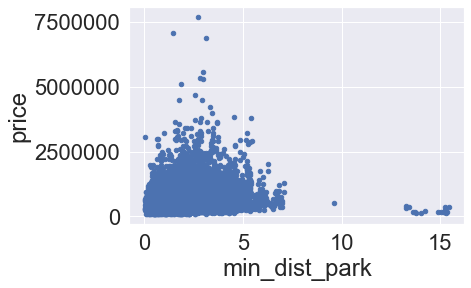

In [106]:
data2.plot.scatter(x='min_dist_park', y='price');
print('corr. price and parks: ' + str(data2['price'].corr(data2['min_dist_park'])))

It was not yet clear whether there was a relationship between proximity to a park and the price of a home. As we continued our exploration, removed outliers, narrowed down our data, and revised our park list to eliminate forests and trail heads, we began to see more of a connection.  

Please see our next notebook, 'data_preparation', for the cleaning, compiling, and transformations of our data.